In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from typing import Callable, Optional
plt.rcParams['figure.figsize'] = (8, 6)
sns.set()
sns.set_context('notebook')

# Heston model

$$ dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^S_t$$
$$ dv_t = \kappa (\theta - v_t)dt + \xi \sqrt{v_t} dW^v_t$$


In [142]:
def simulate_correlated_WN(n_steps, n_paths, corr=0.0, seed = None):
    if isinstance(corr, float):
        corrmat = np.array([[1, corr],
                            [corr, 1]])
    else:
        corrmat = corr
    
    if seed:
        np.random.seed(seed)

    dWs, dWv = np.random.multivariate_normal(mean = np.array([0.0, 0.0]),
                                             cov = corrmat,
                                             size = (n_paths, n_steps)).T
    return dWs, dWv


class Heston:
    def __init__(self, S0, v0, mu, rho, kappa, theta, ksi):
        self.S0 = S0
        self.v0 = v0
        self.mu = mu
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.ksi = ksi
        self._available_schemas = {'EM': 'Euler-Maruyama', 
                                   'EMR': 'Euler-Maruyama: Reflection',
                                   'EMFT': 'Euler-Maruyama: Full truncation',
                                   'M': 'Milstein',
                                   'MR': 'Milstein: Reflection',
                                   'MFT': 'Milstein: Full truncation',
                                   'KJ': 'Kahl-Jackel'}
        if 2*kappa*theta <= (ksi*ksi):
            raise Warning("Feller condition not met (2*kappa*theta - ksi*ksi) is not strictly positive.")
    
    def schema_full_name(self, abbrev):
        return self._available_schemas[abbrev]
    
    def simulate(self, scheme, dt, n_steps=None, n_paths=None, W = None, return_dW = False):
        
        if W is None:
            dWs, dWv = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths, corr=model.rho)
            dWs, dWv = dWs*np.sqrt(dt), dWv*np.sqrt(dt)
        else:
            dWs, dWv = np.diff(W[0], axis = 0), np.diff(W[1], axis =0)
            n_steps = dWs.shape[0]
            n_paths = dWs.shape[1]

        St, vt = np.zeros(shape=(n_steps + 1, n_paths)), np.zeros(shape=(n_steps + 1, n_paths))
        St[0, :], vt[0, :] = model.S0, model.v0

        if scheme == "EM":
            scheme_update = self.euler_maruyama_update
        elif scheme == "M":
            scheme_update = self.milstein_update
        elif scheme == "EMFT":
            scheme_update = self.em_full_truncation_update
        elif scheme == "MFT":
            scheme_update = self.mil_full_truncation_update
        elif scheme == "EMR":
            scheme_update = self.em_reflection_update
        elif scheme == "MR":
            scheme_update = self.mil_reflection_update
        elif scheme == "KJ":
            scheme_update = self.kahl_jackel_update
        else:
            raise ValueError(f"Scheme {scheme} not recognized.")
            
        for i, (dWSi, dWvi) in enumerate(zip(dWs, dWv)):
            St[i + 1, :], vt[i + 1, :] = scheme_update(Sti = St[i, :], vti = vt[i, :],
                                                       dWSi = dWSi, dWvi = dWvi, dt = dt)

        outputs = (St, vt, dWs, dWv) if return_dW else (St, vt)
        return outputs
            
    def euler_maruyama_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - vti)*dt + self.ksi*np.sqrt(vti)*dWvi
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(vti)*dWSi
        return St_next, vt_next
    
    def em_full_truncation_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.maximum(vti, 0))*dt + self.ksi*np.sqrt(np.maximum(vti, 0))*dWvi
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(np.maximum(vti, 0))*dWSi
        return St_next, vt_next

    def em_reflection_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.abs(vti))*dt + self.ksi*np.sqrt(np.abs(vti))*dWvi
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(np.abs(vti))*dWSi
        return St_next, vt_next

    def milstein_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - vti)*dt + self.ksi*np.sqrt(vti)*dWvi + self.ksi**2/4.0*(dWvi**2 - 1)*dt
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(vti)*dWSi + 0.5*Sti*vti*(dWSi**2 - 1)*dt
        return St_next, vt_next  

    def mil_full_truncation_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.maximum(vti, 0))*dt + self.ksi*np.sqrt(np.maximum(vti, 0))*dWvi + self.ksi**2/4.0*(dWvi**2 - 1)*dt
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(np.maximum(vti, 0))*dWSi + 0.5*Sti*np.maximum(vti, 0)*(dWSi**2 - 1)*dt
        return St_next, vt_next  

    def mil_reflection_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.abs(vti))*dt + self.ksi*np.sqrt(np.abs(vti))*dWvi + self.ksi**2/4.0*(dWvi**2 - 1)*dt
        St_next = Sti + self.mu*Sti*dt + Sti*np.sqrt(np.abs(vti))*dWSi + 0.5*Sti*np.abs(vti)*(dWSi**2 - 1)*dt
        return St_next, vt_next  
    
    def kahl_jackel_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = (vti + self.kappa*self.theta*dt + self.ksi*np.sqrt(np.maximum(vti, 0))*dWvi + 0.25*self.ksi**2*dt*(dWvi**2 - 1))/(1 + self.kappa*dt)
        St_next = np.exp(np.log(Sti) + self.mu*dt - 0.25*(vt_next + vti)*dt + self.rho*np.sqrt(np.maximum(vt_next, 0))*dWvi + 0.5*(np.sqrt(np.maximum(vti, 0)) + np.sqrt(np.maximum(vt_next, 0)))*(dWSi - self.rho*dWvi) + 0.25*self.ksi*self.rho*(dWvi**2 - 1)*dt)
        return St_next, vt_next
                         

In [17]:
class BlackScholes:
    def __init__(self, S0, sigma, mu):
        self.S0 = S0
        self.sigma = sigma
        self.mu = mu
        self._available_schemas = {'EM': 'Euler-Maruyama', 
                                   'M': 'Milstein',
                                   'Exact': 'Analytical'}
    
    def schema_full_name(self, abbrev):
        return self._available_schemas[abbrev]
    
    def simulate(self, scheme, dt, n_steps=None, n_paths=None, W = None, return_dW = False):
        
        if W is None:
            dWs, _ = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths, corr=0.0)
        else:
            dWs = np.diff(W, axis=0)
            n_steps = dWs.shape[0]
            n_paths = dWs.shape[1]

        St = np.zeros(shape=(n_steps + 1, n_paths))
        St[0, :] = model.S0

        if scheme == "EM":
            scheme_update = self.euler_maruyama_update
        elif scheme == "M":
            scheme_update = self.milstein_update
        elif scheme == "Exact":
            scheme_update = self.exact_update
        else:
            raise ValueError(f"Scheme {scheme} not recognized.")
            
        for i, dWSi in enumerate(dWs):
            St[i + 1, :] = scheme_update(Sti = St[i, :], dWSi = dWSi, dt = dt)

        outputs = (St, dWs) if return_dW else St
        return outputs
    
    # dSt = mu*St*dt + sig*St*dWt
    def exact_update(self, Sti, dWSi, dt):
        St_next = Sti*np.exp((self.mu - self.sigma**2/2)*dt + self.sigma*dWSi)
        return St_next
    
    def euler_maruyama_update(self, Sti, dWSi, dt):
        St_next = Sti + self.mu*Sti*dt + self.sigma*Sti*dWSi
        return St_next
    
    def milstein_update(self, Sti, dWSi, dt):
        St_next = Sti + self.mu*Sti*dt + self.sigma*Sti*dWSi + 0.5*self.sigma**2*Sti*((dWSi)**2 - dt)
        return St_next

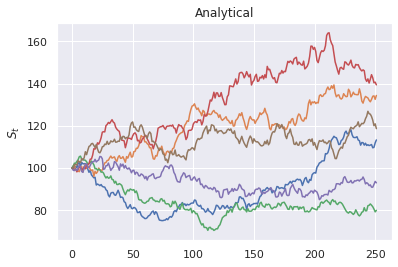

In [45]:
# Simulation setup
T = 1.0
n_steps = 252
n_paths = 6
dt = T/n_steps

# Setup the model
scheme = "Exact"
model = BlackScholes(S0 = 100.0, sigma = 0.2, mu = 0.05)
dWs, _ = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths,
                                corr=0.0)
Wt = (dWs*np.sqrt(dt)).cumsum(axis=0)
St = model.simulate(scheme = scheme, W = Wt, dt = dt)

fig, ax = plt.subplots()
ax.plot(St)
ax.set_ylabel("$S_t$")
ax.set_title(model.schema_full_name(scheme));

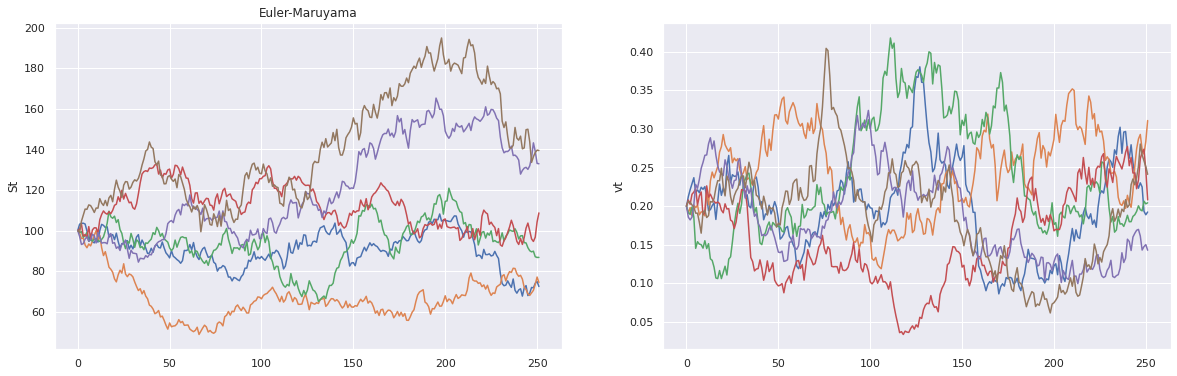

In [145]:
# Simulation setup
T = 1.0
n_steps = 252
n_paths = 6
dt = T/n_steps

model = Heston(S0 = 100.0, v0 = 0.2,
               kappa = 0.7, ksi = 0.5, theta = 0.2, mu = 0.05,
               rho = -0.5)

dWs, dWv = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths,
                                  corr=model.rho, seed=2022)
Ws, Wv = (dWs*np.sqrt(dt)).cumsum(axis = 0), (dWv*np.sqrt(dt)).cumsum(axis = 0)
St, vt = model.simulate(scheme = 'EM', W = (Ws, Wv), dt = dt)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ax[0].plot(St)
ax[0].set_ylabel("St")
ax[0].set_title("Euler-Maruyama")
ax[1].plot(vt)
ax[1].set_ylabel("vt");

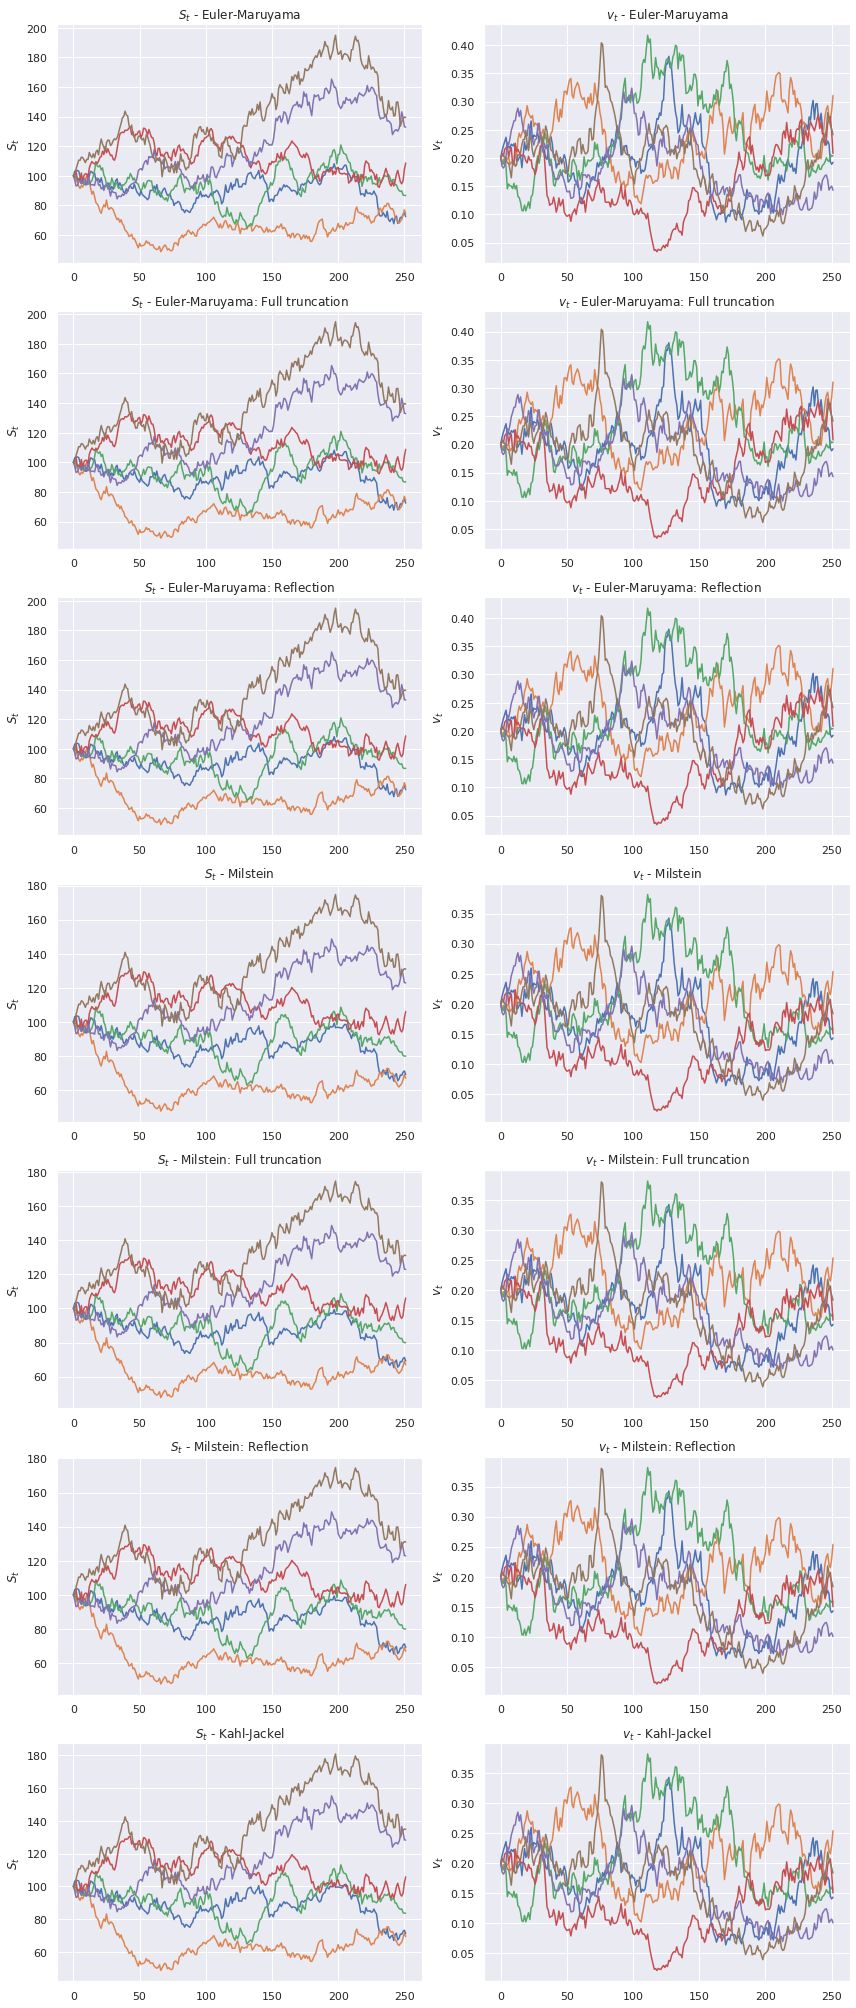

In [146]:
# Simulation setup
n_steps, n_paths = 252, 4
T = 1.0
dt = T/n_steps

fig, ax = plt.subplots(7, 2, figsize=(12, 7*4))

for axis, scheme in zip(ax, ['EM', 'EMFT', 'EMR', 'M', 'MFT', 'MR', 'KJ']):
    St, vt = model.simulate(scheme = scheme, W = (Ws, Wv), dt = dt)

    axis[0].plot(St)
    axis[0].set_ylabel("$S_t$")
    axis[0].set_title(f"$S_t$ - {model.schema_full_name(scheme)}")
    axis[1].plot(vt)
    axis[1].set_title(f"$v_t$ - {model.schema_full_name(scheme)}")
    axis[1].set_ylabel("$v_t$")
plt.tight_layout();

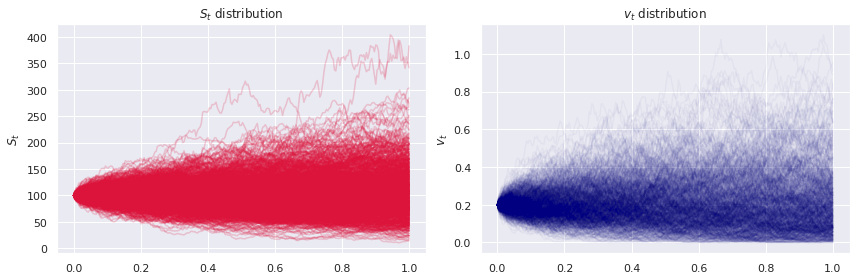

In [60]:
St, vt = model.simulate(scheme = 'EMFT', n_steps = 252, n_paths = 1000, dt = 1/252.)
t = np.linspace(0.0, 1.0, 252+1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t, St, color='crimson', alpha=0.2)
ax[0].set_ylabel("$S_t$")
ax[0].set_title(f"$S_t$ distribution")
ax[1].plot(t, vt, color='navy', alpha=np.sqrt(1/1000))
ax[1].set_title(f"$v_t$ distribution")
ax[1].set_ylabel("$v_t$")
plt.tight_layout();

## Simulation schemes comparison

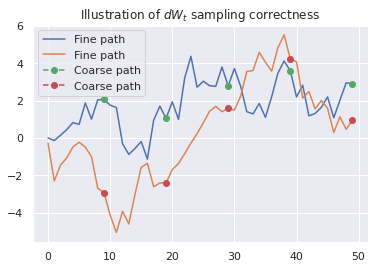

In [61]:
def get_coarse_path(fine_path, mult):
    return fine_path.reshape(-1, mult, fine_path.shape[1]).sum(axis=1)

fine_path, _ = simulate_correlated_WN(n_steps = 50, n_paths = 2, seed = 2022)

mult = 10
coarse_path = get_coarse_path(fine_path, mult)

plt.plot(fine_path.cumsum(axis=0), label='Fine path')
coarse_path_for_plot = fine_path * 0 + np.nan
coarse_path_for_plot[mult-1::mult, :] = coarse_path.cumsum(axis=0)
plt.plot(coarse_path_for_plot, linestyle = "--", marker="o", label='Coarse path')
plt.title("Illustration of $dW_t$ sampling correctness")
plt.legend();

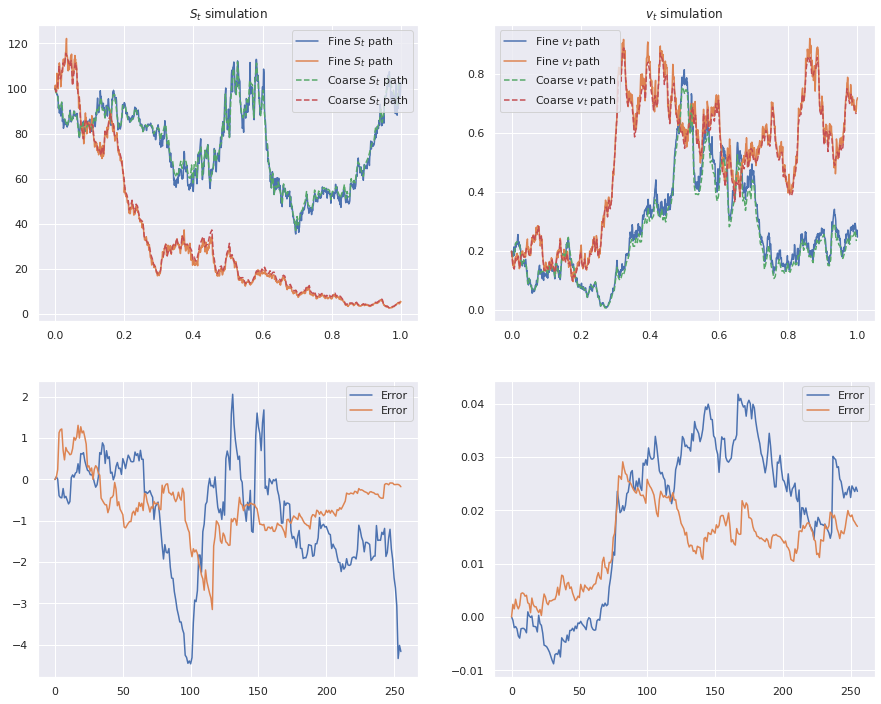

In [77]:
dWs, dWv = simulate_correlated_WN(n_steps = 2**10, n_paths = 2)
Ws, Wv = (dWs*np.sqrt(dt)).cumsum(axis = 0), (dWv*np.sqrt(dt)).cumsum(axis = 0)
fine_St, fine_vt = model.simulate(scheme = "MFT", W = (Ws, Wv), dt = 1./Ws.shape[0])

mult = 4
coarse_St, coarse_vt = model.simulate(scheme = "MFT", W = (Ws[::mult, :], Wv[::mult, :]), dt = 1./(Ws.shape[0]/mult))

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time_axis = np.linspace(0, T, fine_St.shape[0])
ax[0][0].plot(pd.DataFrame(fine_St, index = time_axis), 
           label='Fine $S_t$ path')
ax[0][0].plot(pd.DataFrame(coarse_St, index = time_axis[::mult]), 
           label='Coarse $S_t$ path', linestyle = '--')
ax[0][0].set_title("$S_t$ simulation")
ax[0][0].legend()
ax[1][0].plot(fine_St[::mult, :] - coarse_St, label ='Error')
ax[1][0].legend()

ax[0][1].plot(pd.DataFrame(fine_vt, index = time_axis), 
           label='Fine $v_t$ path')
ax[0][1].plot(pd.DataFrame(coarse_vt, index = time_axis[::mult]), 
           label='Coarse $v_t$ path', linestyle = '--')
ax[0][1].set_title("$v_t$ simulation")
ax[0][1].legend()
ax[1][1].plot(fine_vt[::mult, :] - coarse_vt, label ='Error')
ax[1][1].legend();

## Error analysis

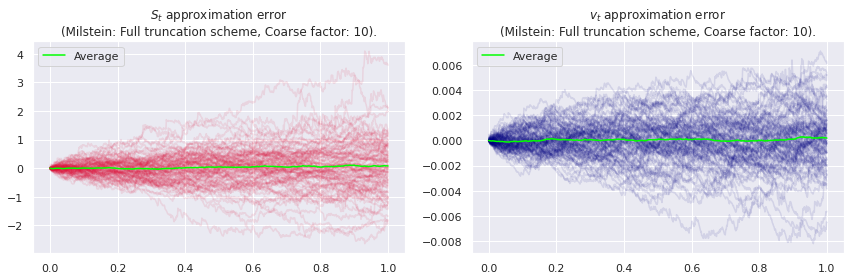

In [82]:
n_fine_steps = 10000
n_paths = 100
mult = 10
scheme = "MFT"

dt_fine = 1.0/n_fine_steps
dt_coarse = 1.0/(n_fine_steps/mult)

dW_fine = simulate_correlated_WN(n_steps = n_fine_steps, n_paths = n_paths, seed = 2022)
W_fine = [(dW*np.sqrt(dt_fine)).cumsum(axis=0) for dW in dW_fine]
W_coarse = [W_fine[::mult, :] for W_fine in W_fine]

sim_fine = model.simulate(scheme = 'MFT', W = W_fine, dt = dt_fine)
sim_coarse = model.simulate(scheme = "MFT", W = W_coarse, dt = dt_coarse)

t_fine = np.linspace(0.0, 1.0, sim_fine[0].shape[0])
t_coarse = np.linspace(0.0, 1.0, sim_coarse[0].shape[0])

diffs = [paths_fine[0::mult, :] - paths_coarse for paths_fine, paths_coarse in zip(sim_fine, sim_coarse)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_coarse, diffs[0], color='crimson', alpha=np.sqrt(1/n_paths))
ax[0].plot(t_coarse, diffs[0].mean(axis=1), color = "lime", label = 'Average')
ax[0].set_title(f"$S_t$ approximation error\n({model.schema_full_name(scheme)} scheme, Coarse factor: {mult}).")
ax[0].legend()

ax[1].plot(t_coarse, diffs[1], color='navy', alpha=np.sqrt(1/n_paths))
ax[1].plot(t_coarse, diffs[1].mean(axis=1), color = "lime", label = 'Average')
ax[1].set_title(f"$v_t$ approximation error\n({model.schema_full_name(scheme)} scheme, Coarse factor: {mult}).")
ax[1].legend()

plt.tight_layout();

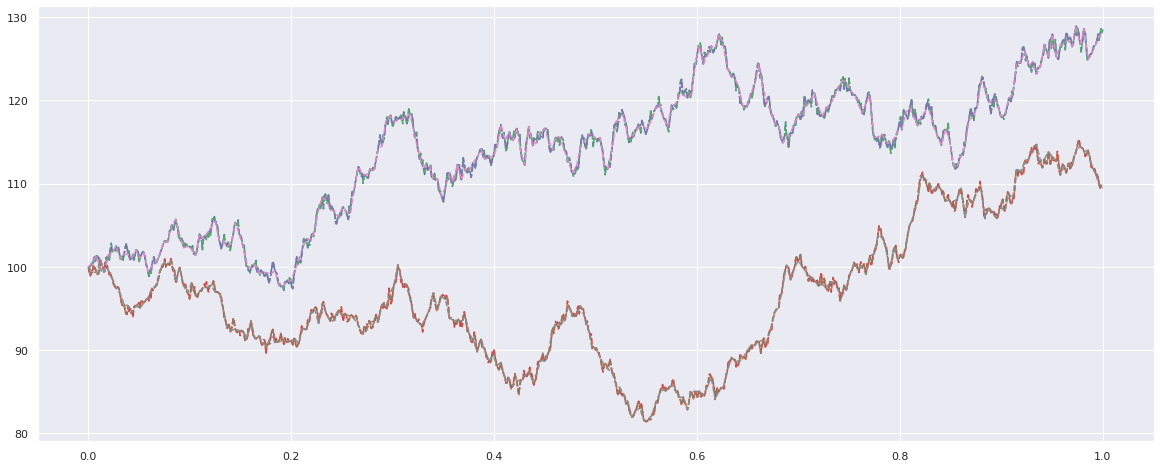

In [94]:
n_fine = 2**10
dW_fine, _ = simulate_correlated_WN(n_steps = n_fine, n_paths = 2, seed = 2022)
dt = T/n_fine
W_fine = (dW_fine*np.sqrt(dt)).cumsum(axis=0)
St_fine = model.simulate(scheme="Exact", W = W_fine, dt = dt)

time_axis = np.linspace(0, 1, St_fine.shape[0])
  
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(pd.DataFrame(St_fine, index = time_axis), 
        label='Fine $S_t$ path', linestyle="-.")

for m in [2**x for x in range(3)]:
  W_coarse = W_fine[::m, :]
  n = int(n_fine/m)
  St = model.simulate(scheme="M", W = W_coarse, dt = T/n)
  ax.plot(pd.DataFrame(St, index = time_axis[::m]), 
          label='Coarse $S_t$ path - EM', linestyle = '--')


Euler-Maruyama: Y = 0.49X + 0.83
Milstein: Y = 1.13X + 0.52


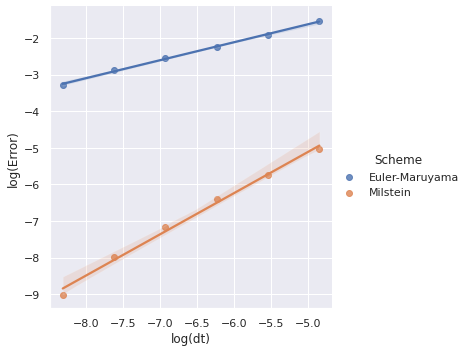

In [141]:
def get_strong_error(fine_path, coarse_path):
    mult = (fine_path.shape[0] - 1)/(coarse_path.shape[0] - 1)
    errs = fine_path[0::int(mult), :] - coarse_path
    return np.max(np.abs(errs).mean(axis=1))

#def get_strong_error(fine_path, coarse_path):
#    errs = fine_path[-1, :] - coarse_path[-1, :]
#    return np.mean(errs**2)


model = BlackScholes(S0 = 100.0, sigma = 0.2, mu = 0.05)

m_grid = [2**x for x in range(1, 7)]
n_fine = 2**13
n_paths = 50
T = 1.0

dt_fine = T/n_fine
dW_fine, _ = simulate_correlated_WN(n_steps = n_fine, n_paths = n_paths)
W_fine = (dW_fine*np.sqrt(dt_fine)).cumsum(axis=0)
mil_fine = model.simulate(scheme="M", W = W_fine, dt = dt_fine)
em_fine = model.simulate(scheme="M", W = W_fine, dt = dt_fine)


errs = {}
for m in m_grid:
    dt_coarse = T/(n_fine/m)
    W_coarse = W_fine[::m, :]

    mil_coarse = model.simulate(scheme = "M", W = W_coarse, dt = dt_coarse)
    em_coarse = model.simulate(scheme = "EM", W = W_coarse, dt = dt_coarse)


    errs[m] = [dt_coarse,
               get_strong_error(em_fine, em_coarse),
               get_strong_error(mil_fine, mil_coarse)]

errs = pd.DataFrame.from_dict(errs, orient='index', columns = ['dt', 'Euler-Maruyama', 'Milstein'])
errs_long = pd.melt(errs, id_vars='dt', value_vars=['Euler-Maruyama', 'Milstein'], var_name = "Scheme", value_name='Error')
errs_long['log(dt)'] = np.log(errs_long['dt'])
errs_long['log(Error)'] = np.log(errs_long['Error'])

lr_eq = []
for err_type in errs_long['Scheme'].unique():
    reg = LinearRegression()
    sub_df = errs_long[errs_long['Scheme'] == err_type]
    reg.fit(X = sub_df['log(dt)'].values.reshape(-1, 1), 
            y = sub_df['log(Error)'].values.reshape(-1, 1))
    lr_eq.append(f"Y = {reg.coef_[0][0]:.2f}X + {reg.intercept_[0]:.2f}")
    print(f"{err_type}: {lr_eq[-1]}")
    
sns.lmplot(data = errs_long, x = 'log(dt)', y='log(Error)', hue='Scheme');

Euler-Maruyama: Full truncation: Y = 0.58X + 3.32
Euler-Maruyama: Reflection: Y = 0.58X + 3.32
Milstein: Full truncation: Y = 0.57X + 3.18
Kahl-Jackel: Y = 0.58X + 2.88


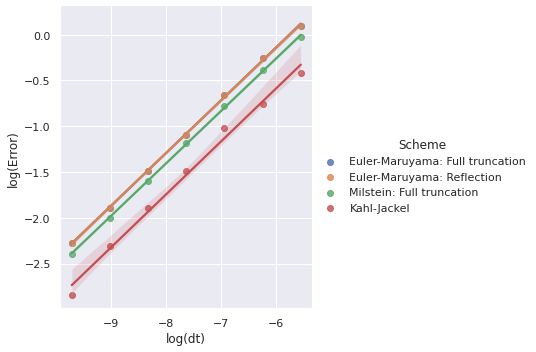

In [182]:
def get_strong_error(fine_path, coarse_path):
    mult = (fine_path.shape[0] - 1)/(coarse_path.shape[0] - 1)
    errs = fine_path[0::int(mult), :] - coarse_path
    return np.max(np.abs(errs).mean(axis=1))

#def get_strong_error(fine_path, coarse_path):
#    errs = fine_path[-1, :] - coarse_path[-1, :]
#    return np.mean(errs**2)



model = Heston(S0 = 100.0, v0 = 0.2,
               kappa = 0.7, ksi = 0.4, theta = 0.2, mu = 0.05,
               rho = -0.5)

m_grid = [2**x for x in range(1, 8)]
n_fine = 2**17
n_paths = 100
T = 1.0

dt_fine = T/n_fine
dW_fine = simulate_correlated_WN(n_steps = n_fine, n_paths = n_paths)
W_fine = [(dw*np.sqrt(dt_fine)).cumsum(axis=0) for dw in dW_fine]

schemes_to_try = ['EMFT', 'EMR', 'MFT', 'KJ']
sim_fine = {scheme_name: model.simulate(scheme=scheme_name, W = W_fine, dt = dt_fine)[0] for scheme_name in schemes_to_try}

errs = {}
for m in m_grid:
    dt_coarse = T/(n_fine/m)
    W_coarse = [w[::m, :] for w in W_fine]

    sim_coarse = {scheme_name: model.simulate(scheme = scheme_name, W = W_coarse, dt = dt_coarse)[0] for scheme_name in schemes_to_try}

    errs[m] = [dt_coarse] + [get_strong_error(sim_fine[scheme_name], sim_coarse[scheme_name]) for scheme_name in schemes_to_try]

errs = pd.DataFrame.from_dict(errs, orient='index', columns = ['dt'] + [model.schema_full_name(scheme_name) for scheme_name in schemes_to_try])
errs_long = pd.melt(errs, id_vars='dt', value_vars=[model.schema_full_name(scheme_name) for scheme_name in schemes_to_try], var_name = "Scheme", value_name='Error')
errs_long['log(dt)'] = np.log(errs_long['dt'])
errs_long['log(Error)'] = np.log(errs_long['Error'])

lr_eq = []
for err_type in errs_long['Scheme'].unique():
    reg = LinearRegression()
    sub_df = errs_long[errs_long['Scheme'] == err_type]
    reg.fit(X = sub_df['log(dt)'].values.reshape(-1, 1), 
            y = sub_df['log(Error)'].values.reshape(-1, 1))
    lr_eq.append(f"Y = {reg.coef_[0][0]:.2f}X + {reg.intercept_[0]:.2f}")
    print(f"{err_type}: {lr_eq[-1]}")
    
sns.lmplot(data = errs_long, x = 'log(dt)', y='log(Error)', hue='Scheme');

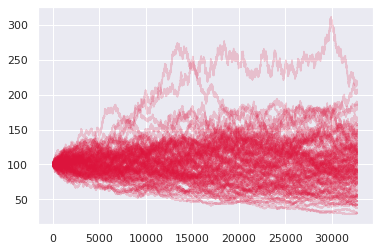

In [183]:
plt.plot(sim_fine[schemes_to_try[0]], alpha = 0.2, color='crimson');

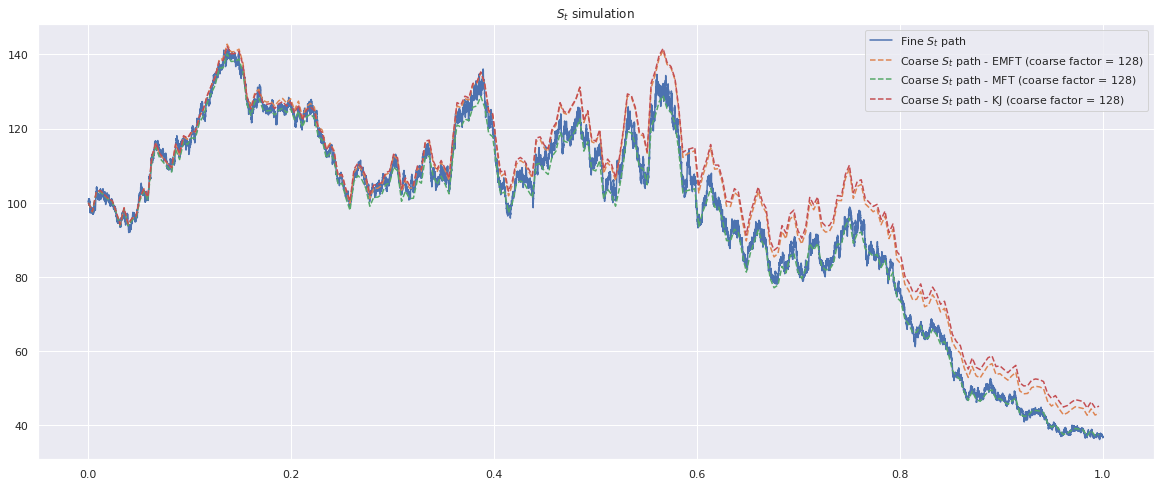

In [177]:
scheme = schemes_to_try[1]
mult = int((sim_fine[scheme].shape[0] - 1)/(sim_coarse[scheme].shape[0] - 1))
p = 1
fig, ax = plt.subplots(figsize=(20, 8))
time_axis = np.linspace(0, T, sim_fine[scheme].shape[0])
ax.plot(pd.DataFrame(sim_fine[scheme][:, p], index = time_axis), 
           label='Fine $S_t$ path')

for scheme in schemes_to_try:
  ax.plot(pd.DataFrame(sim_coarse[scheme][:, p], index = time_axis[::mult]), 
            label=f'Coarse $S_t$ path - {scheme} (coarse factor = {mult})', linestyle = '--')
ax.set_title("$S_t$ simulation")
ax.legend();